In [5]:
%load_ext autoreload
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Seaborn enhances the aesthetics of matplotlib plots
import pandas as pd
import xarray as xr
import seaborn as sns
import math
import matplotlib.colors
import warnings
import os
# sns.set()

from tempest import casestudy
from tempest import grid
from tempest import storm_tracker
from tempest import joint_distrib
from tempest import handler
from tempest.plots.hist import simple_hist

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
settings_paths = ['settings/sam_4km_30min_30d.yaml']
# settings_paths = [
#     "settings/arpege_summer_30d.yaml", 
#     "settings/fv3_summer_30d.yaml" , 
#     "settings/ifs_summer_30d.yaml" , 
#     "settings/mpas_summer_30d.yaml", 
#     "settings/nicam_summer_30d.yaml",
#     "settings/obs_summer_30d.yaml",
#     "settings/obsv7_summer_30d.yaml",
#     "settings/mpas_summer_30d.yaml", 
#     "settings/sam_summer_30d.yaml",
#     "settings/sam_4km_30min_30d.yaml",
#     "settings/screamv1_summer_30d.yaml",  
#     "settings/um_summer_30d.yaml"
#     ]

hdlrs = [handler.Handler(settings_path) for settings_path in settings_paths]
css = [casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False) for hdlr in hdlrs]
grs = [grid.Grid(cs, fast = True, overwrite= False, verbose_steps = False, verbose = False) for cs in css]

Data loaded from /homedata/mcarenso/tempest/SAM_4km_30min_30d_Tropics/var_id_days_i_t.json
Found grid attributes file , so loading /homedata/mcarenso/tempest/SAM_4km_30min_30d_Tropics/grid_attributes.pkl instead of computing
Creating Earth (rough borders)


In [14]:
def make_jds(gr, var_id):
    """
    added 95 and 97 to grid Prec calculus, but need to relaunch everything..
    What is the sensitivity to nbpd ? and nd ? 
    """
    cond_alpha_values = ["00", "01", "05", "10", "20", "25", "33", "40", "50", "60", "67", "75", "80", "85", "90", "99"]
    jds = []
    # Create the base joint  distribution
    jd_xy = joint_distrib.JointDistribution(gr, None, var_id_1=var_id, var_id_2=var_id, nbpd=20, nd=5, overwrite=False, dist_mask=False, verbose=False)
    jds.append(jd_xy)
    # Create joint distributions for each cond_alpha value
    for alpha in cond_alpha_values:
        jd = joint_distrib.JointDistribution(gr, None, var_id_1=var_id, var_id_2=f"cond_alpha_{alpha}_Prec", nbpd=20, nd=5, overwrite=False, dist_mask=False, verbose=False)
        jds.append(jd)
    # Create the max_Prec joint distribution
    jd_max = joint_distrib.JointDistribution(gr, None, var_id_1=var_id, var_id_2="max_Prec", nbpd=20, nd=5, overwrite=False, dist_mask=False)
    jds.append(jd_max)

    return jds[::-1] ##because cond_alpha_values actually corresponds to 1-alpha of the alpha in the paper ~~!>O_._O<!~~

def make_mis(jds, rank_threshold_int=20):
    mi, mi_pos, mi_neg = [], [], []
    for jd in jds:
        jd.compute_joint_density(jd.sample1, jd.sample2, method='default')
        out = jd.mutual_information(rank_threshold_int=rank_threshold_int)
        mi.append(out[0])
        mi_pos.append(out[1]) #unused
        mi_neg.append(out[2]) #unused
    return mi

In [31]:
rank_threshold_int = 20  ## carefull this is an int that corresponds to the selected nbpd * nd in jds initiation

convective_var_ids = [
    "convective_01_Prec", 
    "convective_02_Prec", 
    "convective_03_Prec", 
    "convective_04_Prec", "convective_05_Prec", "convective_06_Prec", "convective_08_Prec", 
    "convective_10_Prec", 
    "convective_12_Prec", 
    "convective_15_Prec",
    "convective_20_Prec", "convective_25_Prec", 
    "convective_30_Prec", 
    "convective_40_Prec", 
    "convective_50_Prec"
]

mis_per_model = []

for i in range(len(settings_paths)):
    gr = grs[i]
    all_mis = {}
    all_jds = {}
    filename = f"mis_rank_start_{rank_threshold_int}.npy"
    filepath = os.path.join(gr.casestudy.data_out, filename)
    print(gr.casestudy.name)
    if os.path.exists(filepath):
        mis = np.load(filepath)
    else : 
        for var_id in convective_var_ids:
            print(var_id)
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=RuntimeWarning)
                jds = make_jds(gr, var_id)
                all_jds[var_id] = jds
                all_mis[var_id] = make_mis(jds, rank_threshold_int = rank_threshold_int)

        # Creating a list of MIs
        mis = [all_mis[var_id] for var_id in convective_var_ids]
        np.save(filepath, mis)
    mis_per_model.append(mis)

ARPEGE_lowRes_Tropics
FV3_lowRes_Tropics
IFS_lowRes_Tropics
MPAS_lowRes_Tropics
NICAM_lowRes_Tropics
OBS_lowRes_Tropics
OBSv7_lowRes_Tropics
MPAS_lowRes_Tropics
SAM_lowRes_Tropics
SAM_4km_30min_30d_Tropics
SCREAMv1_lowRes_Tropics
UM_lowRes_Tropics


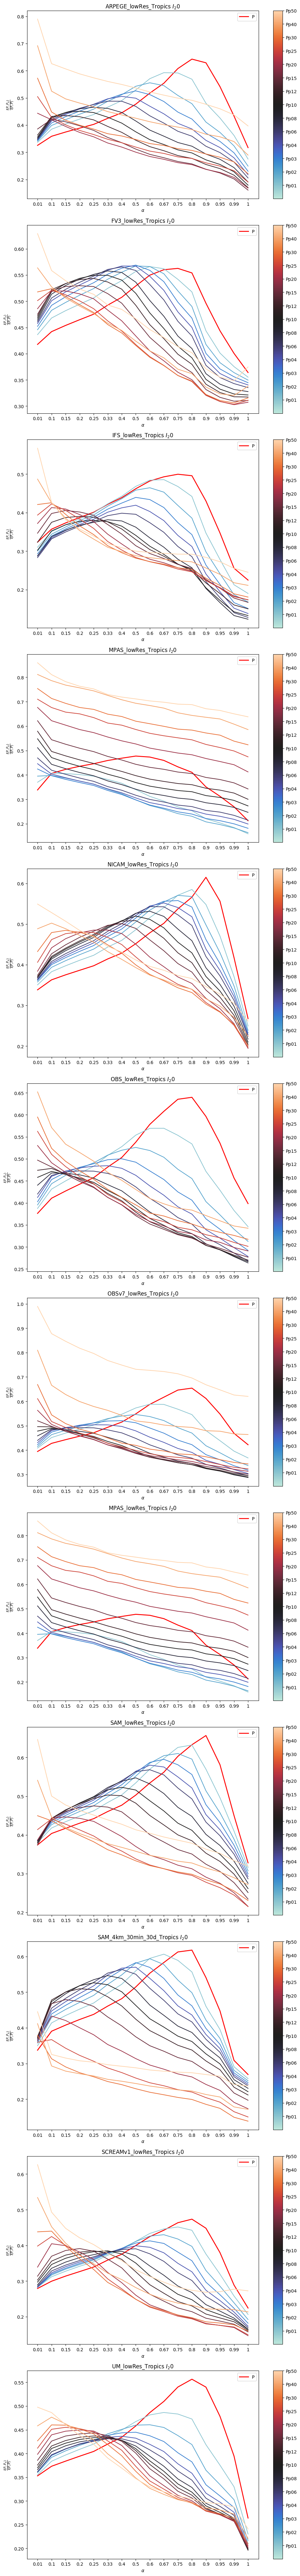

In [34]:
import seaborn as sns
# cond_alpha_values = ["00", "01", "05", "10", "20", "25", "33", "40", "50", "60", "67", "75", "80", "85", "90", "99"]

#  Create a list of alpha values (excluding the first and last to match the plotting)
alphas =["0.01", "0.1", "0.15", "0.2", "0.25", "0.33", "0.4", "0.5", "0.6", "0.67", "0.75", "0.8", "0.9", "0.95", "0.99", "1"]
labels = ["P", "Pp01", "Pp02", "Pp03", "Pp04", "Pp06", "Pp08", "Pp10", "Pp12", "Pp15", "Pp20", "Pp25", "Pp30", "Pp40", "Pp50"]

# Plotting

# Define the colormap
cmap = sns.color_palette("icefire", as_cmap=True)

# Define the values and boundaries
values_and_boundaries = np.arange(0, 0.05 + 0.001, 0.001)
values = values_and_boundaries[1::2]
boundaries = values_and_boundaries[::2]

# Normalize the colormap to the number of labels
norm = plt.Normalize(vmin=0, vmax=len(labels) - 1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
mi_01 = []
mi_15 = []
mi_33 = []
mi_50 = []
mi_conv_01 = []
mi_conv_15 = []
mi_conv_33 = []
mi_conv_50 = []

fig, axs = plt.subplots(12, 1, figsize=(10, 80))
for ax, gr, mis in zip(axs, grs, mis_per_model):
    # Plot the first line with a distinct color and double line width
    first_color = 'red'
    ax.plot(alphas, mis[0][1:-1]/mis[0][-1], label=labels[0], color=first_color, linewidth=2.0)
    for idx, (mi, label) in enumerate(zip(mis[1:], labels[1:]), start=1):
        color = cmap(norm(idx))
        ax.plot(alphas, mi[1:-1]/mi[-1], color=color)
        if label =="P":
            mi_01.append(mi[0])
            mi_15.append(mi[2])
            mi_33.append(mi[5])
            mi_50.append(mi[7])
        elif label == "Pp10":
            mi_conv_01.append(mi[0])
            mi_conv_15.append(mi[2])
            mi_conv_33.append(mi[5])
            mi_conv_50.append(mi[7])
            
    ax.set_xlabel(r'$\alpha$')
    ax.set_ylabel(r'$\frac{I(P, P_{\alpha})}{I(P, P)}$')
    ax.set_title(fr'{gr.casestudy.name} $I_{rank_threshold_int}$')
    ax.legend()

    # Adding color bar
    cbar = plt.colorbar(sm, ax=ax, ticks=range(1, len(labels)))
    cbar.ax.set_yticklabels(labels[1:])

plt.tight_layout()
plt.show()

In [ ]:
np.save()